Imports

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import cluster, datasets

#Import pytorch:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset, random_split
import torchvision
import torchvision.transforms as transforms

To get a feeling for the model and its implementation, some simple tests are done by following instructions on the pytorch website (https://pytorch.org/hub/pytorch_vision_resnext/). A classification task is tried on the pre-trained version of ResNeXt: download images and give it to the model for classification.

In [2]:
import urllib
url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

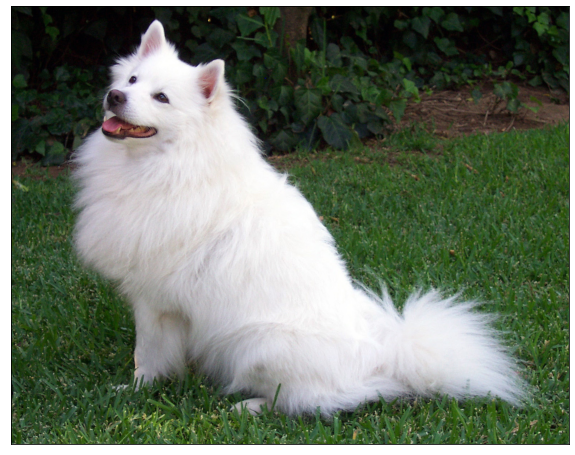

In [3]:
# Display the image
image = plt.imread("dog.jpg")
plt.figure(figsize=(10,10))
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(image)

Load the pre-trained ResNeXt model.

In [4]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnext50_32x4d', pretrained=True)
model.eval()

Using cache found in /home/burger/.cache/torch/hub/pytorch_vision_v0.10.0
/home/burger/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/burger/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

The pre-trained model expects images of a certain format, with 3 feature layers and a 224x224 crop, and normalization. The image of the dog above is pre-processed such that it fulfills the model requirments.

In [5]:
from PIL import Image
#load the image of the dog
input_image = Image.open(filename)
#crop and normalize
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
#apply pre-processing
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

In [6]:
# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)
print(probabilities)

tensor([-3.7869e-01, -8.7607e-01, -1.0458e+00, -1.7807e+00, -2.8490e+00,
         4.5469e-01, -3.1439e-01,  2.4608e+00,  4.6373e+00, -6.8706e-01,
        -2.5154e+00, -1.7253e+00, -1.7181e+00, -1.6819e+00, -2.9249e+00,
        -1.8234e+00, -2.3229e+00, -5.1976e-01, -3.3186e-01, -2.9750e-02,
        -7.6930e-01, -8.5422e-01, -4.5674e-01,  1.6078e+00, -1.9731e+00,
        -1.6912e+00, -1.1963e+00,  7.3291e-01, -8.7231e-01,  3.2870e-01,
        -6.9123e-01,  7.1463e-03,  4.4783e-01, -2.2790e+00, -4.8503e-01,
        -2.4070e+00, -1.0197e+00, -2.8373e+00, -2.2223e+00, -1.7164e+00,
        -1.1307e+00, -2.6178e+00, -3.4507e+00, -2.6316e+00, -1.2086e+00,
        -2.5106e+00, -1.2817e+00, -1.3505e+00, -3.1848e+00, -1.0036e-02,
        -6.0860e-01, -4.1770e-01,  7.5805e-01, -4.4260e-01, -8.0626e-01,
        -1.8484e-01, -1.2000e+00, -6.7037e-01, -1.7177e+00, -5.9533e-01,
         1.5129e+00, -1.5361e+00, -2.4033e+00, -2.5055e+00, -1.0484e+00,
        -2.4362e+00,  4.8588e-01, -9.9675e-01, -9.4

/home/burger/anaconda3/lib/python3.9/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 6050). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525551200/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [7]:
probabilities.shape

torch.Size([1000])

The output tensor has a shape of 1000, the model has been trained with 1000 classes, the entries i of the probabilites tensor give the probability of the image to be of class i

In [8]:
print(torch.max(probabilities))

tensor(0.9957)


The maxmimum probability (result of classification) is more than 99%. Now, the class labels are needed

In [9]:
# Download ImageNet labels
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

--2023-02-28 23:38:58--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8002::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt.1’

imagenet_classes.tx 100%[===================>]  10,23K  --.-KB/s    in 0s      

2023-02-28 23:38:58 (35,9 MB/s) - ‘imagenet_classes.txt.1’ saved [10472/10472]



In [10]:
# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)

for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

Samoyed 0.9956800937652588
Pomeranian 0.001141631742939353
keeshond 0.000910072703845799
white wolf 0.0008333530859090388
chow 0.00046696924255229533


The model classifies the image as Samoyed. According to wikipedia, this is a dog race with a white color as one of the main characteristics. The classification seems to be correct (at least for someone who has no idea about dogs and dog races).

In [11]:
print_cats = categories[0:20]
print(print_cats)

['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead', 'electric ray', 'stingray', 'cock', 'hen', 'ostrich', 'brambling', 'goldfinch', 'house finch', 'junco', 'indigo bunting', 'robin', 'bulbul', 'jay', 'magpie', 'chickadee']


The model seems to mainly able to classify animals. Search other images & classify: Image of a hummingbird taken from wikipedia: https://en.wikipedia.org/wiki/Hummingbird (also, hummingbird is in the class list), a bird of the species blue-footed booby (https://en.wikipedia.org/wiki/Booby , not among the classses), a rocket (https://fr.wiktionary.org/wiki/rocket , not among classes), Star War's Darth Vader (https://en.wikipedia.org/wiki/Darth_Vader). This exercise is mainly to get a feeling for the model and its behaviour.

In [12]:
input_image_hum = Image.open("TestFigures/Hummingbird.jpg")
input_tensor_hum = preprocess(input_image_hum)
input_batch_hum = input_tensor_hum.unsqueeze(0) 

In [13]:
input_image_bo = Image.open("TestFigures/Blue-footed-booby.jpg")
input_tensor_bo = preprocess(input_image_bo)
input_batch_bo = input_tensor_bo.unsqueeze(0) 

In [14]:
input_image_ro = Image.open("TestFigures/Titan_23G_rocket_hurtles_above_the_launch_tower.jpg")
input_tensor_ro = preprocess(input_image_ro)
input_batch_ro = input_tensor_ro.unsqueeze(0) 

In [15]:
input_image_dv = Image.open("TestFigures/Darth_Vader.jpg")
input_tensor_dv = preprocess(input_image_dv)
input_batch_dv = input_tensor_dv.unsqueeze(0) 

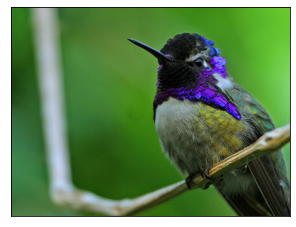

In [16]:
# Display the image
image = plt.imread("TestFigures/Hummingbird.jpg")
plt.figure(figsize=(5,5))
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(image)

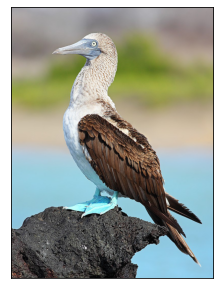

In [17]:
# Display the image
image = plt.imread("TestFigures/Blue-footed-booby.jpg")
plt.figure(figsize=(5,5))
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(image)

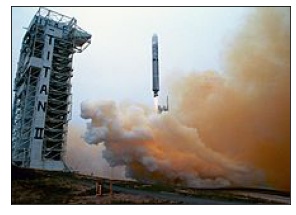

In [18]:
# Display the image
image = plt.imread("TestFigures/Titan_23G_rocket_hurtles_above_the_launch_tower.jpg")
plt.figure(figsize=(5,5))
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(image)

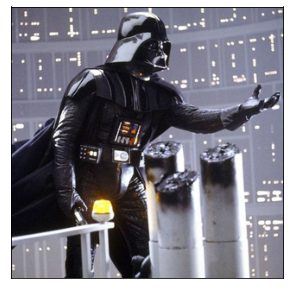

In [19]:
# Display the image
image = plt.imread("TestFigures/Darth_Vader.jpg")
plt.figure(figsize=(5,5))
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(image)

In [20]:
list_images = [input_batch_hum, input_batch_bo, input_batch_ro, input_batch_dv]
output_vec = []
for i in list_images:
    with torch.no_grad():
        output = model(i)
        output_vec.append(output)
probs = []
for j in output_vec[:]:
    probabilities_1 = torch.nn.functional.softmax(j[0], dim=0)
    probs.append(probabilities_1)
print(len(probs))

4


In [21]:
# Show top categories per image
for k in probs:
    top5_prob_1, top5_catid_1 = torch.topk(k, 5)

    for i in range(top5_prob_1.size(0)):
        print(categories[top5_catid_1[i]], top5_prob_1[i].item())
    print("******************")

hummingbird 0.9998990297317505
jacamar 8.870804595062509e-05
water ouzel 9.54742336034542e-06
red-backed sandpiper 3.8934820167924045e-07
redshank 2.1821445272962592e-07
******************
bustard 0.5511255860328674
ruddy turnstone 0.08824015408754349
vulture 0.06375125795602798
kite 0.0613350085914135
red-backed sandpiper 0.03737795352935791
******************
missile 0.5548801422119141
projectile 0.4435693919658661
space shuttle 0.0015179287875071168
warplane 1.5078579963301308e-05
cannon 1.3051675523456652e-05
******************
breastplate 0.32889309525489807
trench coat 0.06166466325521469
gasmask 0.05866844579577446
crash helmet 0.031189600005745888
cuirass 0.027269847691059113
******************


- The classification as hummingbird is correct. The model predicts the image to be in the class hummingbird with high probability.
- The model classifies the blue-feet booby as bustard (a bird species), however, only with a probability of 55%. The model does not know about blue-feet boobies (an exotic and rare bird), however, its classification as a bird is close.
- The rocket is classified as a missile with a probability of 55% but the probability for projectile is close. This classification is close. The model however considers only the center of the image, which shows an object which can be interpreted as a missile or projectile, but it does not seem to know the context (launcher, fire from the jet propulsion), which makes it clear to the human eye that this is a rocket.
- The classification of the Darth Vader image is not even close. The model seems to disintegrate the image in its elements (breastplate, trench coat, mask, helmet).

Given the results above, a further test is done. It has been observed that the model classifies the object in the center of the image. What happens if there are several objects / no object is clearly found in the center?

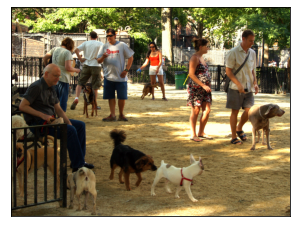

In [22]:
input_image_park = Image.open("TestFigures/Tompkins_Square_Big_Dog_Run.jpg") #https://en.wikipedia.org/wiki/Dog_park
input_tensor_park = preprocess(input_image_park)
input_batch_park = input_tensor_park.unsqueeze(0) 
image = plt.imread("TestFigures/Tompkins_Square_Big_Dog_Run.jpg")
plt.figure(figsize=(5,5))
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(image)

In [23]:
with torch.no_grad():
    output_park = model(input_batch_park)
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities_park = torch.nn.functional.softmax(output_park[0], dim=0)
top5_prob_p, top5_catid_p = torch.topk(probabilities_park, 5)

for i in range(top5_prob_p.size(0)):
    print(categories[top5_catid_p[i]], top5_prob_p[i].item())

wire-haired fox terrier 0.29111310839653015
Lakeland terrier 0.2735072672367096
Brabancon griffon 0.1394980251789093
pug 0.05678240954875946
French bulldog 0.02883201837539673


On this picture,there are several dogs and humans in a park. The model seems to be mainly interested in the dogs but not the humans or what is in the background. It seems to also classify the dogs separately, each with a small probability.

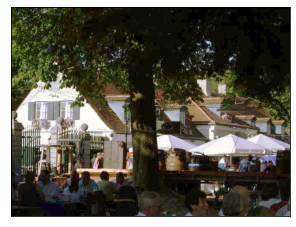

In [24]:
input_image_bg = Image.open("TestFigures/Hirschgarten-muenchen.jpg") #https://fr.wikipedia.org/wiki/Hirschgarten_(Munich)#/media/Fichier:Hirschgarten-muenchen.jpg
input_tensor_bg = preprocess(input_image_bg)
input_batch_bg = input_tensor_bg.unsqueeze(0) 
image = plt.imread("TestFigures/Hirschgarten-muenchen.jpg")
plt.figure(figsize=(5,5))
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(image)

In [25]:
with torch.no_grad():
    output_bg = model(input_batch_bg)

probabilities_bg = torch.nn.functional.softmax(output_bg[0], dim=0)
top5_prob_bg, top5_catid_bg = torch.topk(probabilities_bg, 5)

for i in range(top5_prob_bg.size(0)):
    print(categories[top5_catid_bg[i]], top5_prob_bg[i].item())

restaurant 0.5727108120918274
carousel 0.10628694295883179
lakeside 0.04621949791908264
boathouse 0.03300407901406288
oxcart 0.021519677713513374


There are several objects on this image: people in an outside restaurant, a tree and house with fence and umbrellas. We have no clear centered and large object and the light situation is not advantageous. The model tries to split the image into components: restaurant (true), carousel (false -> misclassification of tree?), boathouse (the house?), lakeside (false), oxcart (false). The classes three to five are completely off, however, they have a low probability.

**2nd part: Model training on own dataset**

Train the ResNeXt model on the Flowers-102 dataset. This training and the tests are done in Google colab however. The model image and log files are downloaded, the plotting scripts can be run locally.

https://www.robots.ox.ac.uk/~vgg/data/flowers/102/README.txt

https://www.robots.ox.ac.uk/~vgg/data/flowers/102/

The dataset content, the classes and the dataset sizes are checked first.

In [26]:
#Check the classes and the dataset size first.
import scipy.io
mat = scipy.io.loadmat('TestFigures/imagelabels_flowers.mat')

In [27]:
print(mat)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNX86, Created on: Thu Feb 19 15:43:33 2009', '__version__': '1.0', '__globals__': [], 'labels': array([[77, 77, 77, ..., 62, 62, 62]], dtype=uint8)}


In [28]:
for i in mat:
    print(i)

__header__
__version__
__globals__
labels


In [29]:
a = mat['labels']  
b = list(mat['__header__']) 
c = list(mat['__version__'])
d = list(mat['__globals__'])

In [30]:
print("a = {}".format(a[0][:]))
print("header = {}".format(b))
print("version = {}".format(c))
print("global = {}".format(d))

a = [77 77 77 ... 62 62 62]
header = [77, 65, 84, 76, 65, 66, 32, 53, 46, 48, 32, 77, 65, 84, 45, 102, 105, 108, 101, 44, 32, 80, 108, 97, 116, 102, 111, 114, 109, 58, 32, 71, 76, 78, 88, 56, 54, 44, 32, 67, 114, 101, 97, 116, 101, 100, 32, 111, 110, 58, 32, 84, 104, 117, 32, 70, 101, 98, 32, 49, 57, 32, 49, 53, 58, 52, 51, 58, 51, 51, 32, 50, 48, 48, 57]
version = ['1', '.', '0']
global = []


In [31]:
np.shape(a)

(1, 8189)

In [32]:
np.unique(a)

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102], dtype=uint8)

Test the classification of one image of the flower-102 dataset on the pre-trained model.

In [33]:
input_image_fw = Image.open("TestFigures/image_08119.jpg")
input_tensor_fw = preprocess(input_image_fw)
input_batch_fw = input_tensor_fw.unsqueeze(0) 

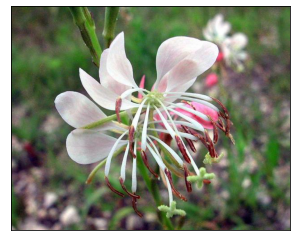

In [34]:
image = plt.imread("TestFigures/image_08119.jpg")
plt.figure(figsize=(5,5))
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(image)

What happens if we apply our pre-trained model to it?

In [35]:
with torch.no_grad():
    output_fw = model(input_batch_fw)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities_fw = torch.nn.functional.softmax(output_fw[0], dim=0)

In [36]:
top5_prob_fw, top5_catid_fw = torch.topk(probabilities_fw, 5)

for i in range(top5_prob_fw.size(0)):
    print(categories[top5_catid_fw[i]], top5_prob_fw[i].item())

pot 0.3373284339904785
daisy 0.11180098354816437
sea anemone 0.05306541547179222
ant 0.05052001774311066
ladybug 0.047947533428668976


The model recognizes the picture as a (flower?) pot. For objects which it is trained on, the model is very good, for other classes it is very vague. This has to be kept in mind and the model has to be trained for the purpose it is used: it has to be decided before the training what it should be used for, if it should recognize dog races, people's faces, plant types etc.

Now, load test and training data from the flower dataset

In [37]:
Data_Train = torchvision.datasets.Flowers102(root='./data', split='train', download=True, transform=preprocess)
Data_Test = torchvision.datasets.Flowers102(root='./data', split='test', download=True, transform=preprocess)
#https://pytorch.org/vision/main/generated/torchvision.datasets.Flowers102.html

In [38]:
X_train = Data_Train._image_files #see here: https://pytorch.org/vision/0.12/_modules/torchvision/datasets/flowers102.html
y_train = Data_Train._labels

In [39]:
print(y_train)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27,

In [40]:
X_test = Data_Test._image_files #see here: https://pytorch.org/vision/0.12/_modules/torchvision/datasets/flowers102.html
y_test = Data_Test._labels

In [41]:
print('Shape of y_test: {}'.format(len(y_test)))
print('Shape of X_test: {}'.format(len(X_test)))
print('Shape of y_train: {}'.format(len(y_train)))
print('Shape of X_train: {}'.format(len(X_train)))

Shape of y_test: 6149
Shape of X_test: 6149
Shape of y_train: 1020
Shape of X_train: 1020


Follow this: https://github.com/prlz77/ResNeXt.pytorch and train the models using google colab. The trained models and the log file (accuracy, losses, epoch etc.) can be downloaded and used for plotting.

Now, attempt to train the model on the flowers-102 dataset with 102 classes (on google colab notebook). 
Options are found here: https://github.com/prlz77/ResNeXt.pytorch/blob/master/train.py#L25 

Run the plotting scripts (modified for personal purposes, original from pytorch resnext implementation.

In [42]:
import os
!pwd
os.chdir('resnext.pytorch/')
!pwd
!python utils/plot_log.py
os.chdir('../')

/home/burger/DUDeepLearning/Exam/ExamRepository/DUDeepLearningExam
/home/burger/DUDeepLearning/Exam/ExamRepository/DUDeepLearningExam/resnext.pytorch
Figure(640x480)
Figure(640x480)
Figure(640x480)
